# 04 — Evaluation & Interpretability

> **Objective:** To evaluate the CatBoost model using accuracy and F1, and to interpret predictions via **feature importance** and (optionally) **SHAP** so that both predictive performance and interpretability are addressed.

This notebook covers:
1. [**Load trained model**](#load-trained-model) — load from `models/` or train in-memory  
2. [**Validation metrics**](#validation-metrics) — accuracy, F1 macro, confusion matrix  
3. [**Feature importance**](#feature-importance) — CatBoost built-in importance  
4. [**SHAP (optional)**](#shap-optional) — explain predictions with SHAP values

### 🧠 Context

The hackathon emphasized both **predictive performance** (accuracy on Public/Private leaderboard) and **interpretability**. CatBoost provides feature importance out of the box; we also show how SHAP can be used to explain individual predictions and global feature effects.

---
### 🧰 Imports

In [1]:
import sys
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

sys.path.insert(0, str(Path().resolve().parent))

from src.config import MODEL_ARTIFACT_DIR, TRAIN_CSV
from src.data import load_train, split_X_y, get_train_val_split
from src.preprocess import clean
from src.features import add_features, get_categorical_feature_names
from src.model import build_model
from src.train import MODEL_FILE, ARTIFACTS_FILE

### 📥 Load Trained Model <a id="load-trained-model"></a>

If a saved model exists, load it; otherwise train a quick model in-memory for demonstration.

In [2]:
model_path = MODEL_ARTIFACT_DIR / MODEL_FILE
artifacts_path = MODEL_ARTIFACT_DIR / ARTIFACTS_FILE

if model_path.exists() and artifacts_path.exists():
    model = CatBoostClassifier()
    model.load_model(str(model_path))
    import pickle
    with open(artifacts_path, "rb") as f:
        artifacts = pickle.load(f)
    print("Loaded saved model and artifacts.")
else:
    print("No saved model; training a quick model for demo.")
    df = load_train()
    df = clean(df)
    df = add_features(df)
    X, y = split_X_y(df, target_col="overqualified")
    y = y.astype(int)
    cat_names = [c for c in get_categorical_feature_names() if c in X.columns]
    cat_indices = [i for i, c in enumerate(X.columns) if c in cat_names]
    model = build_model(iterations=200, verbose=0)
    model.fit(X, y, cat_features=cat_indices)
    artifacts = {"feature_cols": X.columns.tolist()}
    X_eval, y_eval = X, y
    cat_indices_eval = cat_indices

feature_cols = artifacts.get("feature_cols", [])

Loaded saved model and artifacts.


Prepare evaluation data (train/val split if we loaded saved model).

In [3]:
if model_path.exists():
    df = load_train()
    df = clean(df)
    df = add_features(df)
    train_df, val_df = get_train_val_split(df, val_size=0.2, random_state=42)
    X_eval, y_eval = split_X_y(val_df, target_col="overqualified")
    y_eval = y_eval.astype(int)
    X_eval = X_eval[feature_cols]
else:
    X_eval = X_eval[feature_cols]

pred = model.predict(X_eval)
print("Validation accuracy:", round(accuracy_score(y_eval, pred), 4))
print("Validation F1 (macro):", round(f1_score(y_eval, pred, average="macro"), 4))

Validation accuracy: 0.7166
Validation F1 (macro): 0.673


### 📊 Validation Metrics <a id="validation-metrics"></a>

Confusion matrix and per-class view.

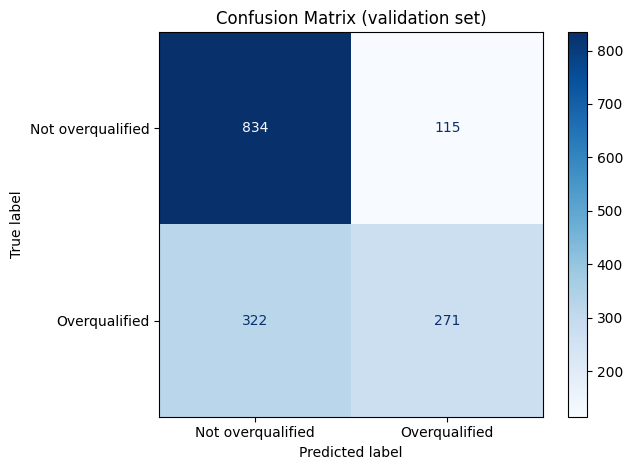

In [4]:
cm = confusion_matrix(y_eval, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not overqualified", "Overqualified"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (validation set)")
plt.tight_layout()
plt.show()

### 📈 Feature Importance <a id="feature-importance"></a>

CatBoost built-in feature importance (e.g. PredictionValuesChange or LossFunctionChange).

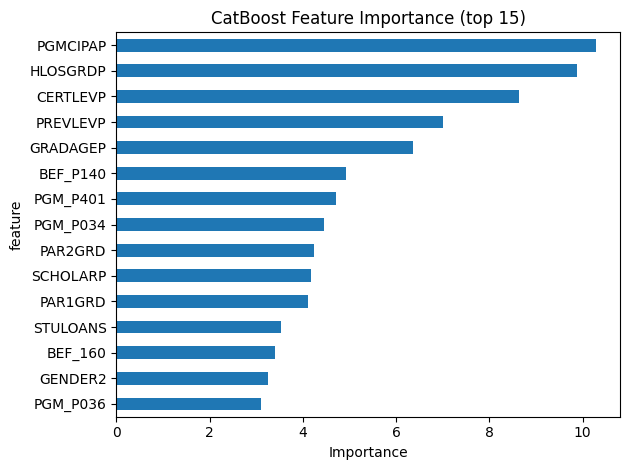

Top 10 features:
 feature  importance
PGMCIPAP   10.286912
HLOSGRDP    9.876986
CERTLEVP    8.634014
PREVLEVP    7.013001
GRADAGEP    6.372024
BEF_P140    4.919947
PGM_P401    4.701096
PGM_P034    4.452001
 PAR2GRD    4.242986
SCHOLARP    4.166253


In [5]:
importance = model.get_feature_importance()
names = model.feature_names_
imp_df = pd.DataFrame({"feature": names, "importance": importance}).sort_values("importance", ascending=False)

imp_df.head(15).plot(x="feature", y="importance", kind="barh", legend=False)
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance (top 15)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 features:")
print(imp_df.head(10).to_string(index=False))

### 🔍 SHAP (optional) <a id="shap-optional"></a>

If `shap` is installed, compute SHAP values on a sample for global feature importance and example explanations.

In [6]:
try:
    import shap
    # Use a sample for speed
    sample_size = min(200, len(X_eval))
    X_sample = X_eval.sample(n=sample_size, random_state=42)
    explainer = shap.TreeExplainer(model, X_sample)
    shap_values = explainer.shap_values(X_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # positive class
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title("SHAP summary (sample)")
    plt.tight_layout()
    plt.show()
except ImportError:
    print("SHAP not installed. pip install shap to enable SHAP plots.")

SHAP not installed. pip install shap to enable SHAP plots.


---
## 📝 Summary

We evaluated the model with accuracy and F1, plotted the confusion matrix, and inspected CatBoost feature importance. Optional SHAP analysis provides instance-level and global interpretability.

**Next step:** `05_pipeline_demo.ipynb` — end-to-end pipeline demonstration.